In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import datetime
from scipy import stats
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 10

First we retrieve relevant dispatcher events using Dune. Check out the SQL queries here: 
- Worker **Commitments** https://dune.xyz/queries/48938
This pulls, on each period, each (staker) address – whose correspondng worker successfully committed to the next period. 
- Staker **Locks** https://dune.xyz/queries/54332
This pulls, on each period, any token locking event by a staker and the sum of tokens locked.
- Staker **Withdrawals** https://dune.xyz/queries/54339
This pulls, on each period, any token withdrawal event by a staker and the sum of tokens withdrawn. 

Note that the Locks and Withdrawals tables do not include preallocated holdings or the growth in stakes due to restaking, and so underestimate the total capital staked at a given period – hence this notebook is WIP. For now, this study provides some insight into the variance of committed capital period-to-period, how this impacts the fluctuations of the break-even stake size, and how this in turn affects the population of nodes (addresses) and their respective solvencies. 

In [2]:
df_c = pd.read_csv(r'commitments.csv')
df_l = pd.read_csv(r'locks.csv')
df_w = pd.read_csv(r'withdrawals.csv')
df_c['timestamp'] = pd.to_datetime(df_c['timestamp']) #standardize the date format
df_l['timestamp'] = pd.to_datetime(df_l['timestamp'])
df_w['timestamp'] = pd.to_datetime(df_w['timestamp'])
df_c['timestamp'] = df_c['timestamp'].dt.date
df_l['timestamp'] = df_l['timestamp'].dt.date
df_w['timestamp'] = df_w['timestamp'].dt.date

In [4]:
# Join the three tables into one 
df_temp = pd.merge(df_c, df_l, how='left', on=['Staker', 'timestamp']) 
df_merged = pd.merge(df_temp, df_w, how='left', on=['Staker', 'timestamp'])
df_merged.fillna(0, inplace=True)

In [6]:
#We focus on node behavior up until the period duration extension on April 14th 2021 (i.e. the era when periods were 1 day long)
split_date = pd.to_datetime('2021-04-15')
df_1day = df_merged.loc[(df_merged['timestamp'] < split_date)]
df_7day = df_merged.loc[(df_merged['timestamp'] >= split_date)]

/Users/arjun/opt/miniconda3/envs/myenv/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [8]:
#We calculate a rudimentary value for each stake value on every period that the associated worker commits. 
df_1day = df_1day.groupby(['timestamp','Staker']).sum().groupby(level='Staker').cumsum()
df_1day['Staked'] = df_1day['Locked'].copy() - df_1day['Withdrawn'].copy()
df_1day

period        Locked  \
timestamp  Staker                                                             
2020-10-15 \x000000b424ca716ba3b1095321216aae2ac412e0       1  0.000000e+00   
           \x000001dc0668cf89e9bab6daaa01822132c9829b       1  0.000000e+00   
           \x0000032ccc3f5e494a30a354f2ca8649b5246965       1  0.000000e+00   
           \x000003379cc5026a3b3b9dd13a733dbbf1278d05       1  0.000000e+00   
           \x000003c63bfe00c235d3233b3de02a2bb8bfe9ed       1  0.000000e+00   
...                                                       ...           ...   
2021-04-14 \xff2fed9cb48196ec35fd97b290c583e7a63b17b7  176424  1.500000e+06   
           \xff86557af05b3e67401edd572cff884709085ccc  196332  4.728513e+06   
           \xff8a662fab0745a5032ccf326fd14b235fa88c2b  257886  1.695000e+06   
           \xffa7fa47a24c49c03bb97fc253daa621b6c94d13     183  1.500000e+04   
           \xffc8995f71f903f42c27081ab2f644db730dc543  182817  1.530000e+06   

                                                           Withdrawn  \
timestamp  Staker                                                      
2020-10-15 \x000000b424ca716ba3b1095321216aae2ac412e0       0.000000   
           \x000001dc0668cf89e9bab6daaa01822132c9829b       0.000000   
           \x0000032ccc3f5e494a30a354f2ca8649b5246965       0.000000   
           \x000003379cc5026a3b3b9dd13a733dbbf1278d05       0.000000   
           \x000003c63bfe00c235d3233b3de02a2bb8bfe9ed       0.000000   
...                                                              ...   
2021-04-14 \xff2fed9cb48196ec35fd97b290c583e7a63b17b7       0.000000   
           \xff86557af05b3e67401edd572cff884709085ccc  228512.797102   
           \xff8a662fab0745a5032ccf326fd14b235fa88c2b       0.000000   
           \xffa7fa47a24c49c03bb97fc253daa621b6c94d13       0.000000   
           \xffc8995f71f903f42c27081ab2f644db730dc543       0.000000   

                                                          Staked  
timestamp  Staker                                                 
2020-10-15 \x000000b424ca716ba3b1095321216aae2ac412e0        0.0  
           \x000001dc0668cf89e9bab6daaa01822132c9829b        0.0  
           \x0000032ccc3f5e494a30a354f2ca8649b5246965        0.0  
           \x000003379cc5026a3b3b9dd13a733dbbf1278d05        0.0  
           \x000003c63bfe00c235d3233b3de02a2bb8bfe9ed        0.0  
...                                                          ...  
2021-04-14 \xff2fed9cb48196ec35fd97b290c583e7a63b17b7  1500000.0  
           \xff86557af05b3e67401edd572cff884709085ccc  4500000.0  
           \xff8a662fab0745a5032ccf326fd14b235fa88c2b  1695000.0  
           \xffa7fa47a24c49c03bb97fc253daa621b6c94d13    15000.0  
           \xffc8995f71f903f42c27081ab2f644db730dc543  1530000.0  

[229571 rows x 4 columns]

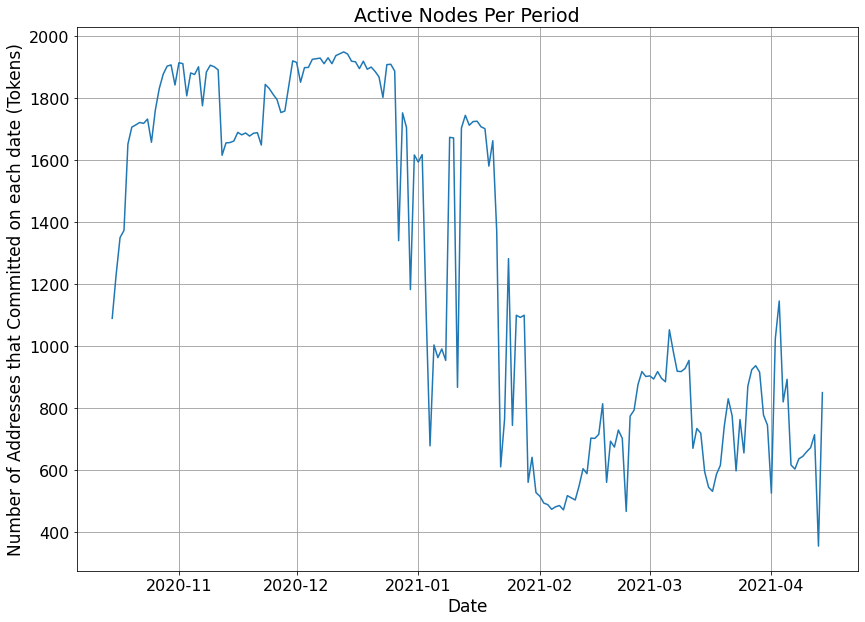

In [11]:
# First we plot the number of commitments (i.e. active workers) at each period 
ActiveWorkers_1day = df_1day.groupby('timestamp')['Staked'].count()
ActiveWorkers_1day = pd.DataFrame(ActiveWorkers_1day)
ActiveWorkers_1day.index = pd.to_datetime(ActiveWorkers_1day.index)

plt.plot(ActiveWorkers_1day)
plt.title('Active Nodes Per Period', fontsize=19)
plt.xlabel('Date', fontsize=17)
plt.ylabel('Number of Addresses that Committed on each date (Tokens)', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.yscale('log')
plt.grid(b=True, which='major', color='#999999', linestyle='-')

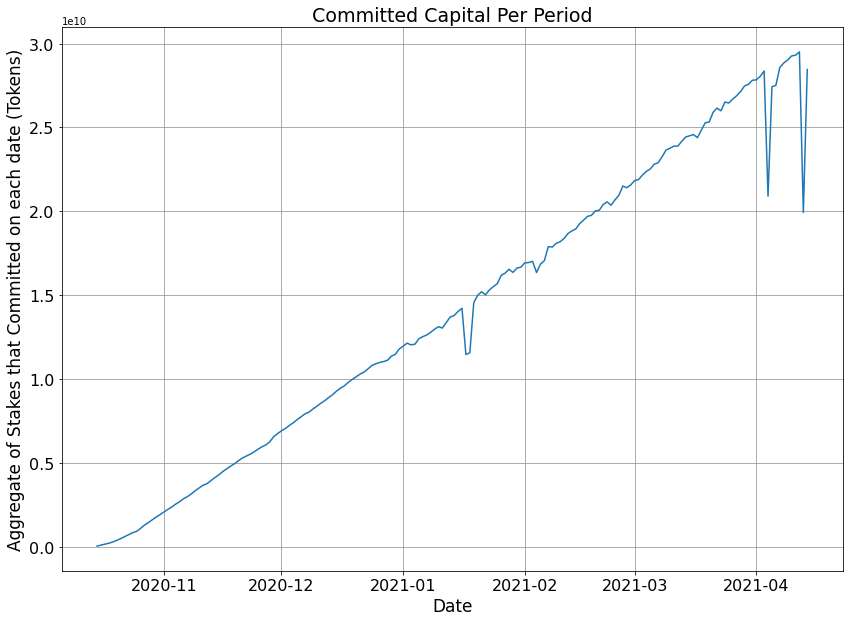

In [13]:
# Now we can compare this to the change in committed capital (i.e. the sum of tokens which made a commitment each period) over the same period 
CommmitedCapital_1day = df_1day.groupby('timestamp')['Staked'].sum()
CommmitedCapital_1day = pd.DataFrame(CommmitedCapital_1day)
CommmitedCapital_1day.index = pd.to_datetime(CommmitedCapital_1day.index)
#ComCap_1day.to_csv('CommittedCapital')
plt.plot(CommmitedCapital_1day)
plt.title('Committed Capital Per Period', fontsize=19)
plt.xlabel('Date', fontsize=17)
plt.ylabel('Aggregate of Stakes that Committed on each date (Tokens)', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.yscale('log')
plt.grid(b=True, which='major', color='#999999', linestyle='-')